# Bike Sharing Challenge (JDA)

####  Creator: Prateek Rawat
#### Date: 05/17/2019

## Table of Contents:
- ### Data Description
    
    
    
- ### Exploratory Data Analysis
    1. Data Preparation
    2. Data Visualization
    3. Feature Distribution
    4. Feature Selection and Engineering


    
- ### Model Design and Analysis
    1. Linear Regression Without Regularization
    2. Linear Regression With Ridge
    3. Linear Regression with Lasso
    4. Random Forest Regressor

## References
    1. https://scikit-learn.org/stable/
    2. https://seaborn.pydata.org/
    3. https://pandas.pydata.org/pandas-docs/stable/
    4. https://stackoverflow.com/
    5. An Introduction to Statistical Learning (By: Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani)
   
   

In [1]:
# Imports to build models
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer,mean_squared_error
from scipy.stats import skew
from scipy.stats import norm
from scipy.stats import kurtosis
from IPython.display import display
import matplotlib.pyplot as plt
import pandas_profiling
import seaborn as sns
from scipy.stats import norm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#Checking Anaconda Version
import sys
sys.version

'3.6.1 |Anaconda custom (64-bit)| (default, May 11 2017, 13:25:24) [MSC v.1900 64 bit (AMD64)]'

### Data Description

#### This dataset is about Bike-Sharing rental process which is highly correlated to the environment and seasonal settings. Our aim is to predict the total  count(cnt) of Bike booked per hour based on these characteristics..
#### The core data set is related to  the two-year historical log corresponding to years 2011 and 2012 from Capital Bikeshare system, Washington D.C., USA which is publicly available in http://capitalbikeshare.com/system-data.

#### Dataset Consist of the following fields
    - instant: record index
	- dteday : date
	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

#### The Data is being ingested from a website and it is present in zip folder. So calling URL and extracting the required dataset

In [3]:
z = urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip')
myzip = ZipFile(BytesIO(z.read())).extract('hour.csv')
df = pd.read_csv(myzip)

### Exploratory Data Analysis



In [4]:
# Use panda_profiling to perform intial EDA on dataset
pandas_profiling.ProfileReport(df)

Number of variables,17
Number of observations,17379
Total Missing (%),0.0%
Total size in memory,2.3 MiB
Average record size in memory,136.0 B
Numeric,11
Categorical,1
Boolean,3
Date,0
Text (Unique),0
Rejected,2


#### Data Profiling Findings:-
    1. Total 17 variables with no missing values.
    2. Variables data types are not as per the data description.So,we have to convert them into their respect data types.
    3. atemp and temp variables have high correlation so we will discard one of them based on correlation matrix and their distribution.
    4. dteday has high cardinality as it represent the date of the year.
    5. Windspeed has zero because their are some days where their in no wind as per weather forecast.
    6. Some of the variables can been seen as skewed so we check id they are normally distributed or not.
    7. Sample at bottom of the profiling page shows the smaple data.

#### Function duplicate is created to check for dulicated for any dataset we pass through it.

In [5]:
# Check for duplicates
def duplicate(df):
    if df.empty:
        print ("Please Provide Dataset")
    else :
        idsUnique = len(set(df.instant))
        idsTotal = df.shape[0]
        idsDupli = idsTotal - idsUnique
    print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")
    return df

data = duplicate(df)

There are 0 duplicate IDs for 17379 total entries


#### As found from data profiling, convert some of the variables into categorical variables for one hot encoding.

In [6]:
# As per the data description some of the variables are categorical but presented as int/float 
#so we will change the datatype to categorical
categorical = ['season', 'yr','mnth','hr','holiday','workingday','weathersit','weekday','dteday']
for var in categorical:
    data[var] = data[var].astype("category")

In [7]:
## Checking datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null category
season        17379 non-null category
yr            17379 non-null category
mnth          17379 non-null category
hr            17379 non-null category
holiday       17379 non-null category
weekday       17379 non-null category
workingday    17379 non-null category
weathersit    17379 non-null category
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: category(9), float64(4), int64(4)
memory usage: 1.3 MB


In [8]:
# Function to calculate correlation
def correlation(df,type):
    if df.empty:
        print ("Pass DataFrame")
    else:
        temp=df
# Compute the correlation matrix
        corr = temp.corr(method=type)

        mask = np.array(corr)

# Turning the lower-triangle of the array to false
        mask[np.tril_indices_from(mask)] = False
        fig,ax = plt.subplots()
        sns.heatmap(corr, 
            mask=mask,
            vmax=.8, 
            square=True,
            annot=True,
            ax=ax)

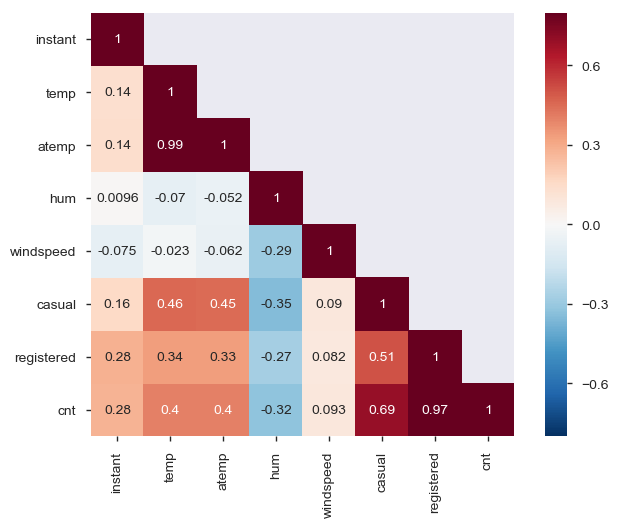

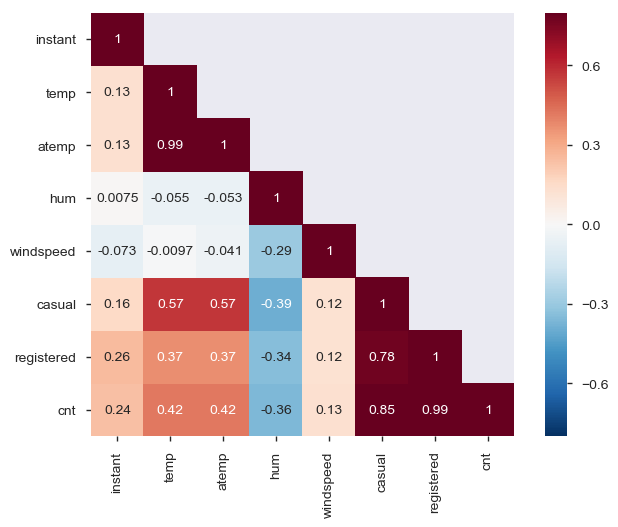

In [9]:
values = ['pearson','spearman']
for cor in values:
    correlation(data,cor)

#### Correlation function is created to calculate person and spearson correlation.
    1. The Pearson correlation evaluates the linear relationship between two continuous variables. A relationship is linear 
    when a change in one variable is associated with a proportional change in the other variable.
    2. The Spearman correlation evaluates the monotonic relationship between two continuous or ordinal variables. 


In [10]:
# Function norm is created to calculate skewness,kurtosis, and data distribution
def norm(df,col):
    if df.empty:
        print ("Pass DataFrame")
    else:
        from scipy.stats import norm
        sns.distplot(df[col], fit=norm);
        fig = plt.figure()
        #skewness and kurtosis
        print("Skewness of column {} => ".format(col), "{:2f}".format(data[col].skew()))
        print("Kurtosis of column {} => ".format(col), "{:2f}".format(data[col].kurt())) 

Skewness of column cnt =>  1.277412
Kurtosis of column cnt =>  1.417203
Skewness of column casual =>  2.499237
Kurtosis of column casual =>  7.571002
Skewness of column registered =>  1.557904
Kurtosis of column registered =>  2.750018
Skewness of column temp =>  -0.006021
Kurtosis of column temp =>  -0.941844
Skewness of column atemp =>  -0.090429
Kurtosis of column atemp =>  -0.845412
Skewness of column hum =>  -0.111287
Kurtosis of column hum =>  -0.826117
Skewness of column windspeed =>  0.574905
Kurtosis of column windspeed =>  0.590820


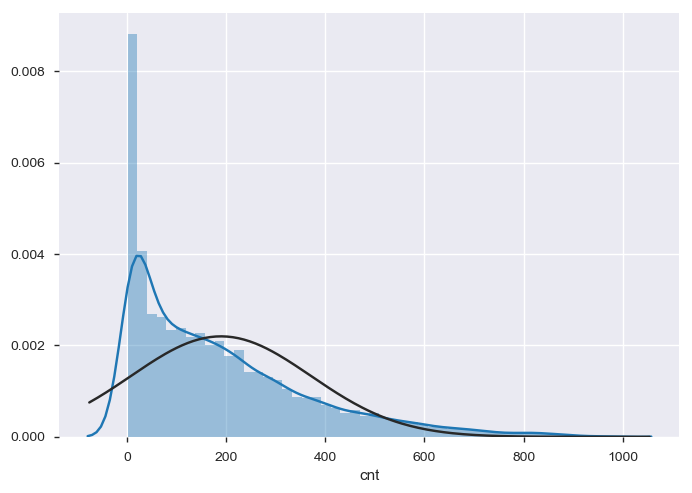

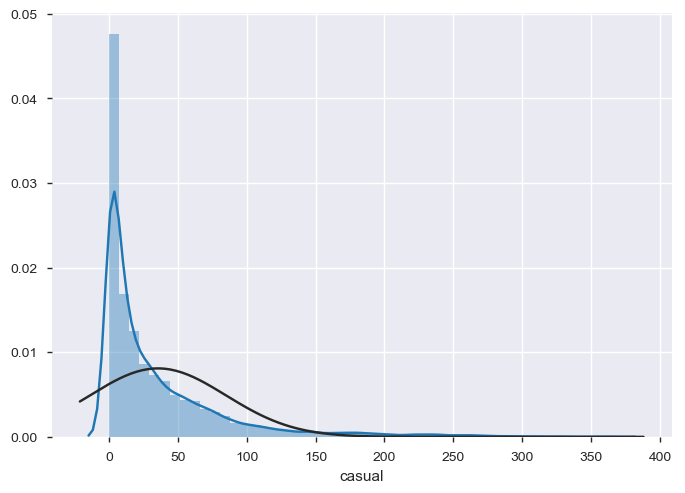

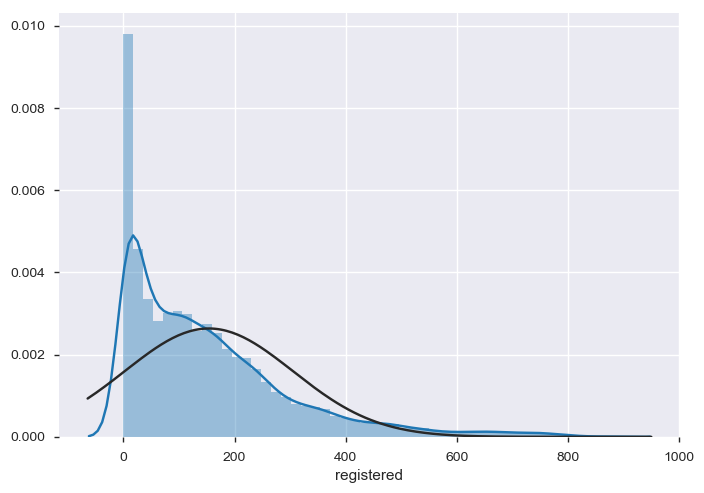

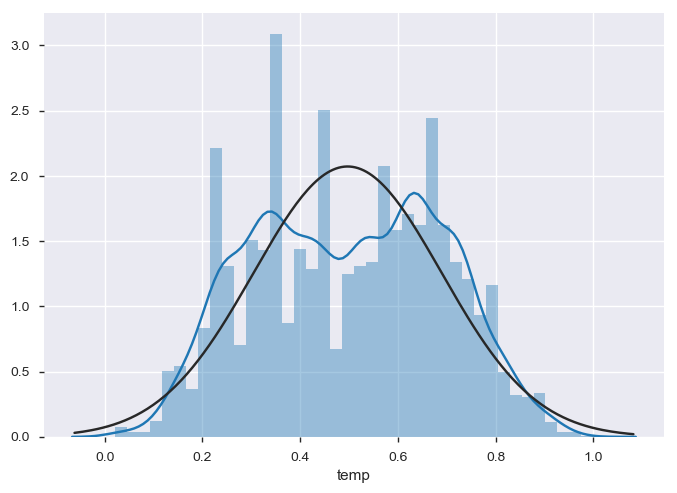

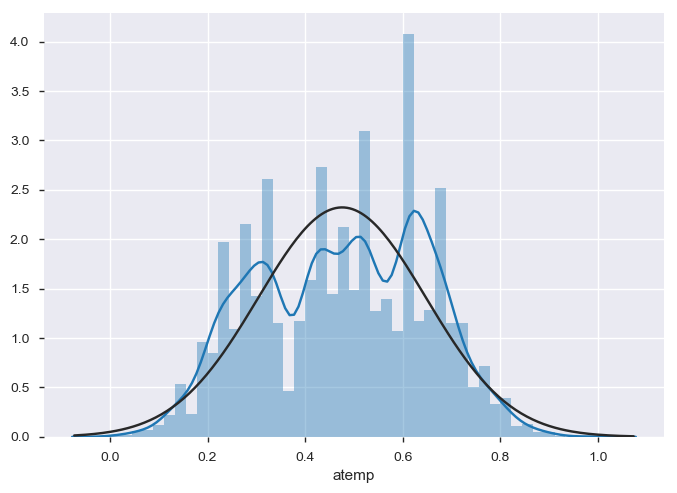

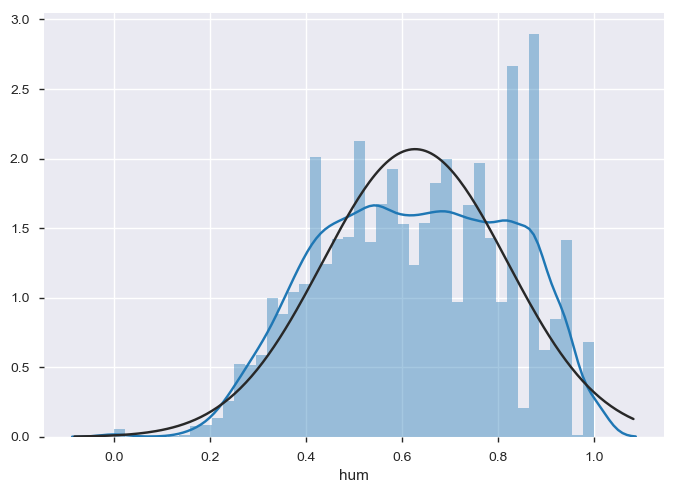

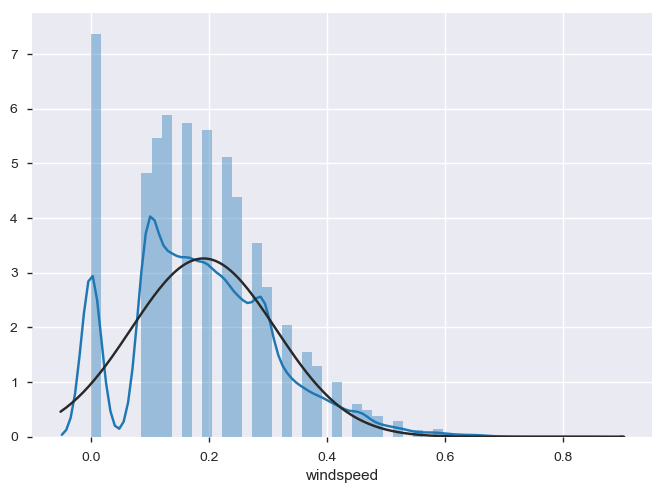

<Figure size 800x550 with 0 Axes>

In [11]:
values = ['cnt','casual','registered','temp','atemp','hum','windspeed']
for col in values:
    norm(data,col)

#### Function norm is created to calculate skewness,kurtosis, and data distribution.
     1. Skewness is the degree of distortion from the symmetrical bell curve or the normal distribution so,if the skewness is between -0.5 and 0.5, the data are fairly symmetrical.
     2.If the skewness is between -1 and -0.5(negatively skewed) or between 0.5 and 1(positively skewed), the data are moderately skewed.
    3.If the skewness is less than -1(negatively skewed) or greater than 1(positively skewed), the data are highly skewed.
    4.Kurtosis is all about the tails of the distribution — not the peakedness or flatness. It is used to describe extreme values in one versus the other tail. It is actually the measure of outliers present in the distribution.
    5.(Kurtosis < 3): Distribution is shorter, tails are thinner than the normal distribution. The peak is lower and broader than Mesokurtic, which means that data are light-tailed or lack of outliers.

In [12]:
# Log transform function
def logTransform(df,col):
    if df.empty:
        print ("Pass DataFrame")
    else:
        df[col] = np.log1p(data[col])
    return df



In [13]:
values = ['cnt','casual','registered']
for col in values:
    logTransform(data,col)

Skewness of column cnt =>  -0.818180
Kurtosis of column cnt =>  -0.179517
Skewness of column casual =>  -0.230087
Kurtosis of column casual =>  -0.878455
Skewness of column registered =>  -0.819644
Kurtosis of column registered =>  -0.132613


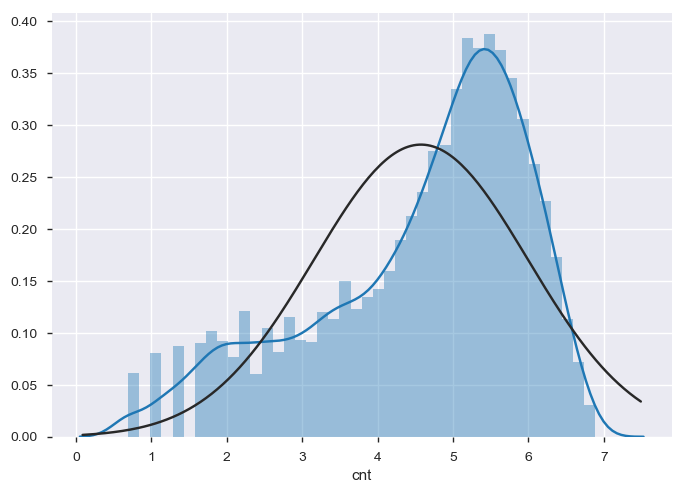

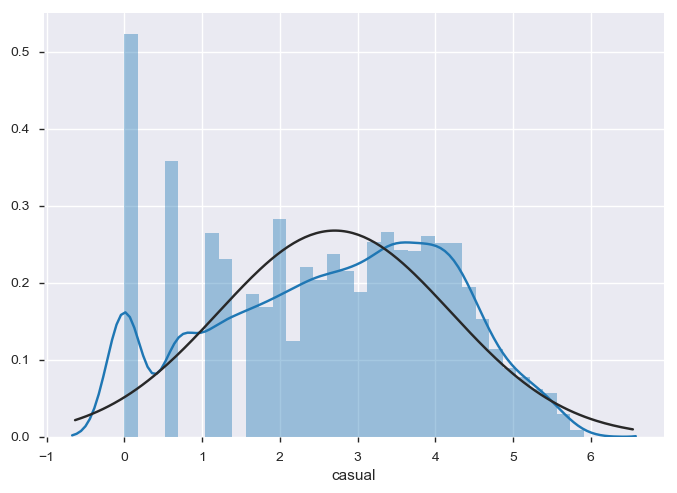

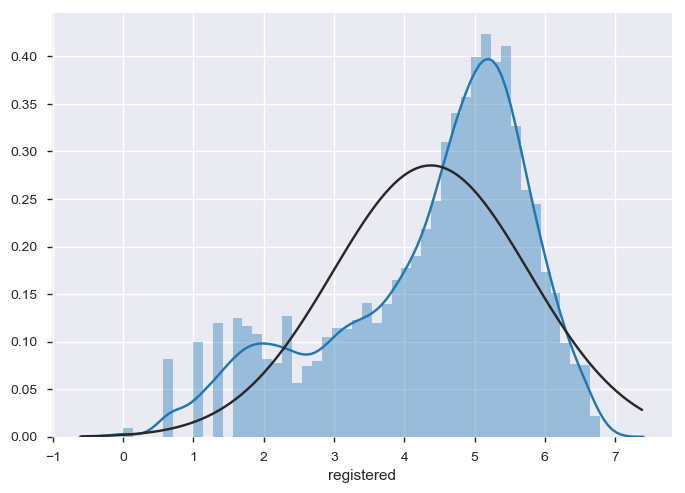

<Figure size 800x550 with 0 Axes>

In [14]:
values = ['cnt','casual','registered']
for col in values:
    norm(data,col)

#### Created Function logTransform to reduce right skewness of variables.
    1. Variables cnt, regsitered,casual are right skewed with greater kutosis and skew than normal.
    2. After log transformation on 'cnt','casual','registered' the skewness has been reduced and this will help to give us better model prediction as data is now almost normally distributed.
    3. Kurtosis shown above for all variables shows that there are less / no outliers in data.
    4. Based on these observation, no outlier check is made on the variables.
   

In [15]:
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,1.386294,2.639057,2.833213
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,2.197225,3.496508,3.713572
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,1.791759,3.332205,3.496508
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,1.386294,2.397895,2.639057
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0.000000,0.693147,0.693147


[Text(0,0.5,'Users Count'),
 Text(0.5,0,'Hour Of The Day'),
 Text(0.5,1,'Average Users Count By Hour Of The Day Across Season'),
 None]

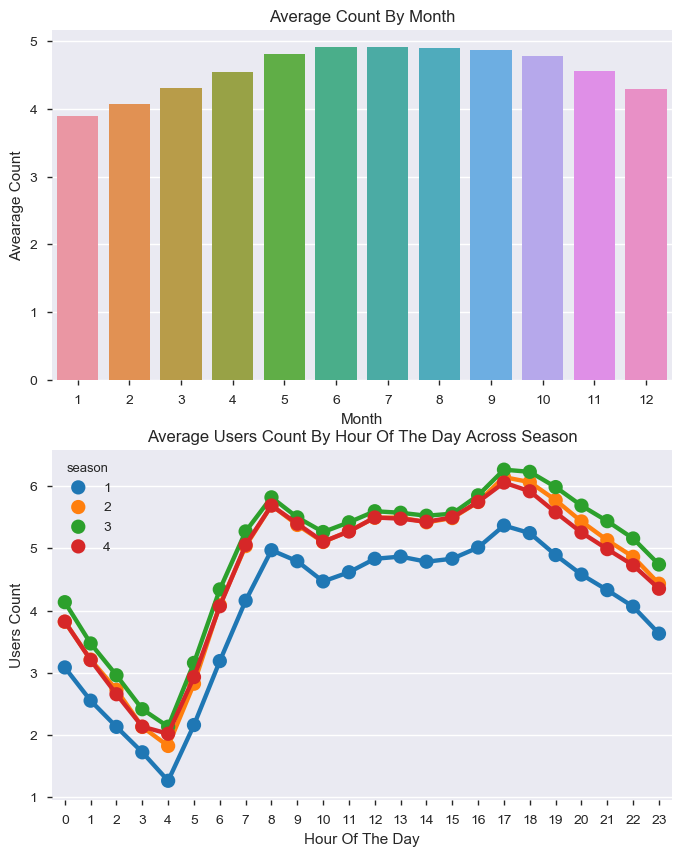

In [16]:
# Plots to check relation of categorical variables
fig,(ax1,ax2)= plt.subplots(nrows=2)
fig.set_size_inches(8,10)

hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(data.groupby("mnth")["cnt"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="cnt",ascending=False)
sns.barplot(data=monthSorted,x="mnth",y="cnt",ax=ax1)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

hourAggregated = pd.DataFrame(data.groupby(["hr","season"],sort=True)["cnt"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hr"], y=hourAggregated["cnt"],hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')



#### Checking Relation of 'cnt' with categorical variables. When ploted graphs of categorical variables such as mnth,hr,season against count of bikes.
    1. Count of bikes increased from march(3) and keep almost constant till october(10).
    2. It can be seen that during winter season the total count of bikes decreased.
    3. We could also find that peak time to hae maximum count of bikes is during 8 a.m. and 5-6 p.m.
    

#### Feature Selection and Engineering

In [17]:
# Funcrion to create dummy varibale using one hot encoding for categoricals
dataDummy = data

def dummify_dataset(df, column):       
    df = pd.concat([pd.get_dummies(df[column], prefix=column, drop_first=False),df],axis=1)
    df = df.drop([column], axis=1)
    return df

columns_to_dummify = ['season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit','yr']
for column in columns_to_dummify:
    dataDummy = dummify_dataset(dataDummy, column)
    
dataDummy.head(2)

,yr_0,yr_1,weathersit_1,weathersit_2,weathersit_3,weathersit_4,workingday_0,workingday_1,weekday_0,weekday_1,...,season_4,instant,dteday,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,0,0,1,0,0,0,...,0,1,2011-01-01,0.24,0.2879,0.81,0.0,1.386294,2.639057,2.833213
1,1,0,1,0,0,0,1,0,0,0,...,0,2,2011-01-01,0.22,0.2727,0.80,0.0,2.197225,3.496508,3.713572


#### Before Choosing a Model
      1. Drop variable 'atemp' based on correlation matrix,skewnwss and kutosis.
      2. From Pearson and Spearman correlaion matrix it can be seen that variables has linear relation so we will go Linear Regression Model followed by Ridge, Lasso.
      3. Also run Random Forest Regressor on label dataset seperately to compare it with Linear Regression.
      4. Though varaible casual and registered has high correlation with our dependent variable but as we are building model for affect of natual condition like season,weather,hour etc on total count of bikes so we will discared these varaibles for Linear Regression Model.
      5. Also the dependent variable is continuous numeric so applying Regrssion make sense.

In [18]:
#Dropping Variables for modelling dataset
# Even though casual and registered have strong relation with cnt we have discarded them from the model prediction 
#because these 2 variables just summing up to give cnt.
dataDummy = dataDummy.drop(dataDummy[['dteday','atemp','instant','casual','registered']],axis=1)


In [19]:
dataDummy.head()

,yr_0,yr_1,weathersit_1,weathersit_2,weathersit_3,weathersit_4,workingday_0,workingday_1,weekday_0,weekday_1,...,mnth_11,mnth_12,season_1,season_2,season_3,season_4,temp,hum,windspeed,cnt
0,1,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0.24,0.81,0.0,2.833213
1,1,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0.22,0.80,0.0,3.713572
2,1,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0.22,0.80,0.0,3.496508
3,1,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0.24,0.75,0.0,2.639057
4,1,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0.24,0.75,0.0,0.693147


In [20]:
dataDummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 61 columns):
yr_0            17379 non-null uint8
yr_1            17379 non-null uint8
weathersit_1    17379 non-null uint8
weathersit_2    17379 non-null uint8
weathersit_3    17379 non-null uint8
weathersit_4    17379 non-null uint8
workingday_0    17379 non-null uint8
workingday_1    17379 non-null uint8
weekday_0       17379 non-null uint8
weekday_1       17379 non-null uint8
weekday_2       17379 non-null uint8
weekday_3       17379 non-null uint8
weekday_4       17379 non-null uint8
weekday_5       17379 non-null uint8
weekday_6       17379 non-null uint8
holiday_0       17379 non-null uint8
holiday_1       17379 non-null uint8
hr_0            17379 non-null uint8
hr_1            17379 non-null uint8
hr_2            17379 non-null uint8
hr_3            17379 non-null uint8
hr_4            17379 non-null uint8
hr_5            17379 non-null uint8
hr_6            17379 non-null uint8
hr_

In [21]:
#Splitting data into feature variables and target variables
X_data = dataDummy.iloc[:, :-1]
y = dataDummy.iloc[:, -1]

In [22]:
# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (12165, 60)
X_test : (5214, 60)
y_train : (12165,)
y_test : (5214,)


#### As numerical variables are calculated at different scales we will standardize them to bring them to a common scale so that all the varaibales should have same effect on model.
#### Standardization cannot be done before the partitioning, as we don't want to fit the StandardScaler on some observations that will later be used in the test set.

In [23]:
# Standardize numerical features 
stdSc = StandardScaler()
X_train.iloc[:, -3:] = stdSc.fit_transform(X_train.iloc[:, -3:])
X_test.iloc[:, -3:] = stdSc.transform(X_test.iloc[:, -3:])

In [24]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 5))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 5))
    return(rmse)

#### Model Implementation

RMSE on Training set : 0.5889581289214753
RMSE on Test set : 0.5971279838150481
R-squared 0.82


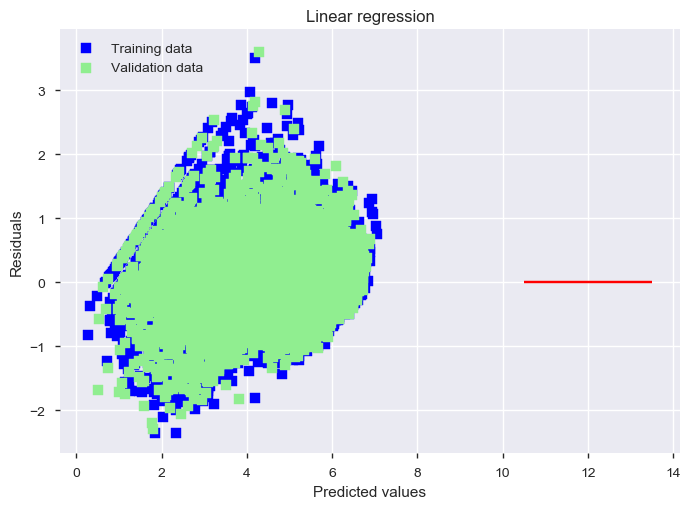

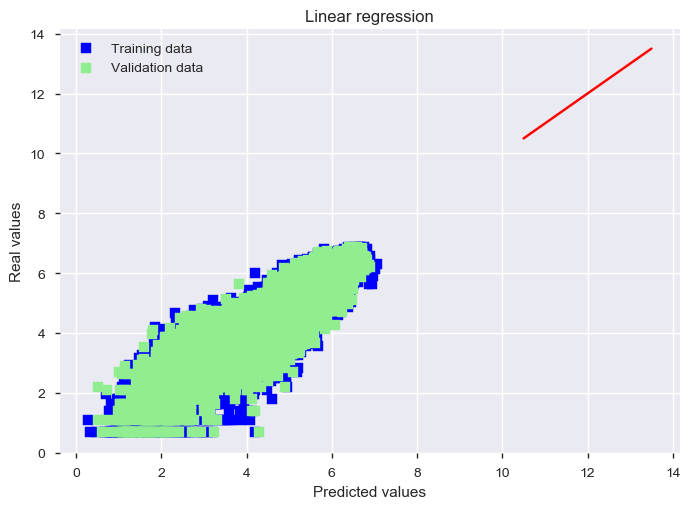

In [25]:
# Linear Regression without Regularization
lr = LinearRegression()
lr.fit(X_train, y_train)

# Look at predictions on training and validation set
print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
test_score_pred = lr.score(X_test,y_test) 
print("R-squared {:.2f}".format(test_score_pred))

# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()


# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()




1.	RMSE on Training set : 0.5889581289214753
2.	RMSE on Test set : 0.5971279838150481
3.	R-squared on Test  0.82

R- squared of 0.82 shows that model has done pretty well as the model has explained a variance of 82% from the total variance present in the model. RMSE of 0.59 on bikes count (target variable) explains that the model has performed well to maintain the bias. It can be seen the from the graphs above that Predicted values have covered almost every point of real values in the dataset which means it has covered most of the explanatory information.
Linear Regression without Regularization has performed well to maintain bias-variance trade off in the prediction the count of bikes used per hour.


Best alpha : 1.0
Try again for more precision with alphas centered around 1.0
Best alpha : 1.4
Ridge RMSE on Training set : 0.5887396159222844
Ridge RMSE on Test set : 0.5959129862887973
Ridge R-squared 0.82


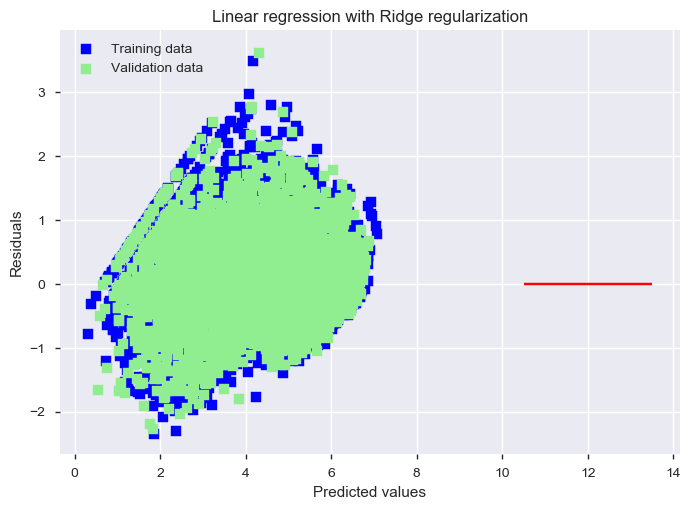

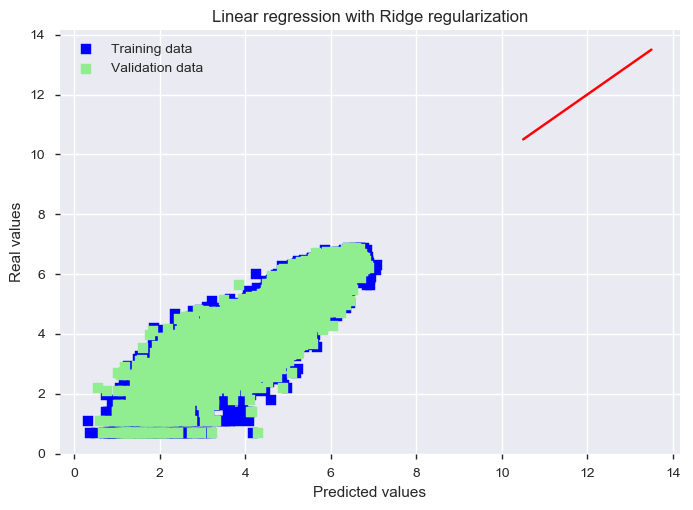

Ridge picked 60 features and eliminated the other 0 features


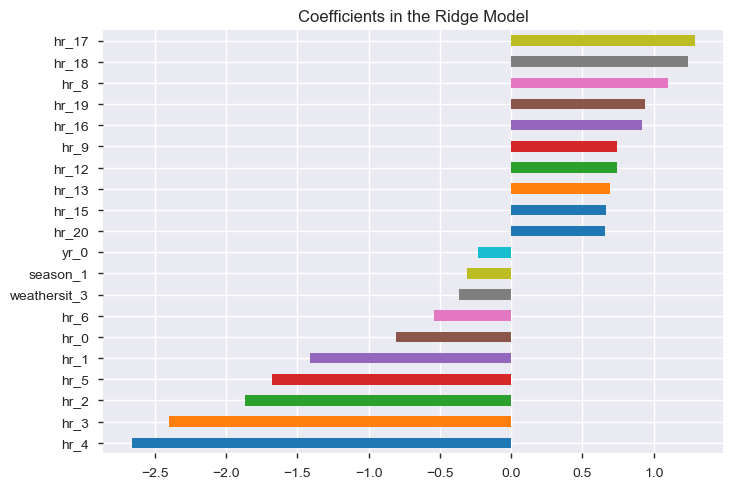

In [26]:
# Linear Regression with Ridge
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 5)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Ridge RMSE on Training set :", rmse_cv_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(ridge).mean())
y_train_rdg = ridge.predict(X_train)
y_test_rdg = ridge.predict(X_test)
test_score_rdg = ridge.score(X_test,y_test) 
print("Ridge R-squared {:.2f}".format(test_score_rdg))

# Plot residuals
plt.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()


# Plot predictions
plt.scatter(y_train_rdg, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

#### Linear Regression with Ridge has given almost same RMSE and R-Squared Linear Regression Wihout Regularization.

Best alpha : 0.0001
Try again for more precision with alphas centered around 0.0001
Best alpha : 0.000105
Lasso RMSE on Training set : 0.5886105779269961
Lasso RMSE on Test set : 0.5958140267862262
Lasso R-squared 0.82


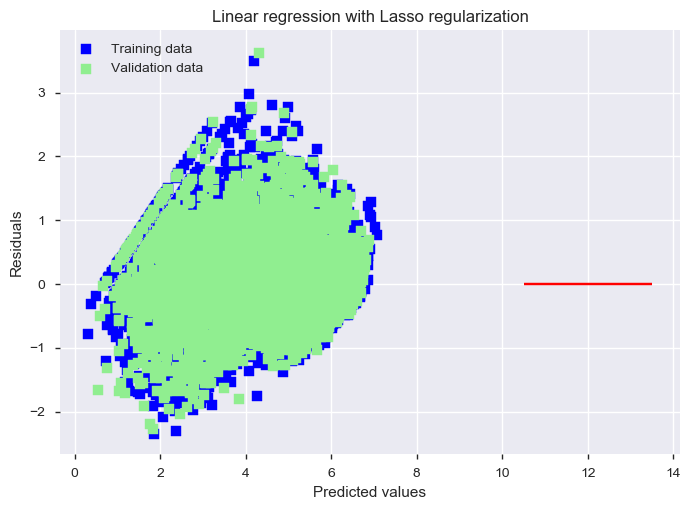

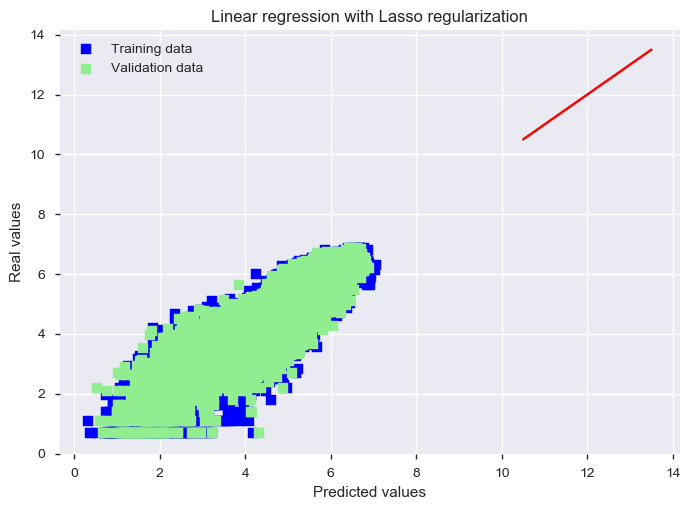

Lasso picked 55 features and eliminated the other 5 features


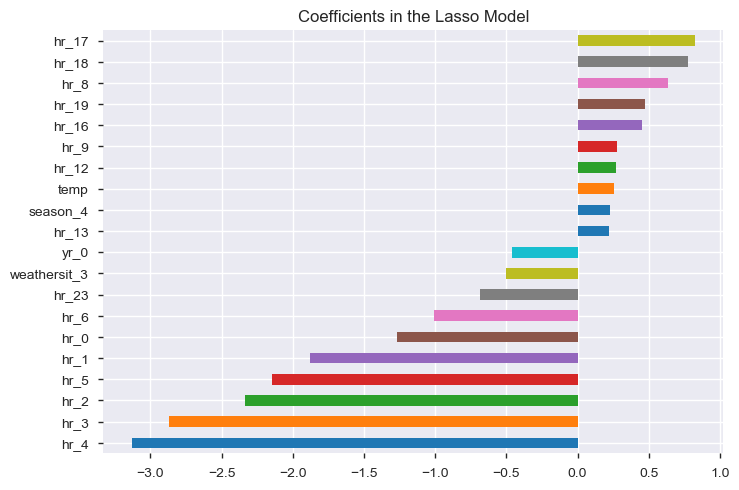

In [27]:
# Linear Regression with Lasso
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 5)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)
test_score_lasso = lasso.score(X_test,y_test) 
print("Lasso R-squared {:.2f}".format(test_score_lasso))

# Plot residuals
plt.scatter(y_train_las, y_train_las - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test_las - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_las, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

#### Linear Regression with Lasso has given almost same RMSE and R-Squared as Linear Regression Wihout Regularization.

### Final Result
#### Selecting Linear Regression Without Regularization

    1. RMSE and R-Squared calculated from Models: Linear Regression without Regularization, Linear Regression with Ridge, and Linear Regression with Lasso are almost similar which means there is no multicollinearity, overfitting, and noise issues with Linear Regression without Regularization model, and it has handled well the sparse dataset which he got after one-hot encoding.
    2. As Linear Regression without Regularization is giving us good results we will go with this model as compared to Linear Regression with Ridge, and Linear Regression with Lasso because Linear Regression without Regularization is computationally less complex to run as compared to other models.


## Problem 2

## Demo for New Model With Larger Dataset and With More Computational Power

### This is an approch where data is in terabytes and we have good computational power.

#### Suppose the number of categorical variables are increased to 500 in the feature space so doing one hot encoding and applying Linear Regression would be a tedious task.

#### Instead we can keep our dataset as a label encoded and apply Random Forest Regressor to select important variables and than apply random forest to predict our outputs.

In [28]:
# Downloading the datast
z = urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip')
myzip = ZipFile(BytesIO(z.read())).extract('hour.csv')
df1 = pd.read_csv(myzip)

In [29]:
#Dropping Variables for modelling dataset
df1 = df1.drop(df1[['dteday','instant','casual','registered']],axis=1)

In [30]:
# making datatypes to categorical
categorical = ['season', 'yr','mnth','hr','holiday','workingday','weathersit','weekday']
for var in categorical:
    df1[var] = df1[var].astype("category")
    
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 13 columns):
season        17379 non-null category
yr            17379 non-null category
mnth          17379 non-null category
hr            17379 non-null category
holiday       17379 non-null category
weekday       17379 non-null category
workingday    17379 non-null category
weathersit    17379 non-null category
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
cnt           17379 non-null int64
dtypes: category(8), float64(4), int64(1)
memory usage: 817.0 KB


In [31]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train1(model):
    rmse= np.sqrt(-cross_val_score(model, X_train1, y_train1, scoring = scorer, cv = 5))
    return(rmse)

def rmse_cv_test1(model):
    rmse= np.sqrt(-cross_val_score(model, X_test1, y_test1, scoring = scorer, cv = 5))
    return(rmse)

In [32]:
# taking dependent and independent variables 
y_t = df1.iloc[:,-1]
X_t = df1.iloc[:, : -1]

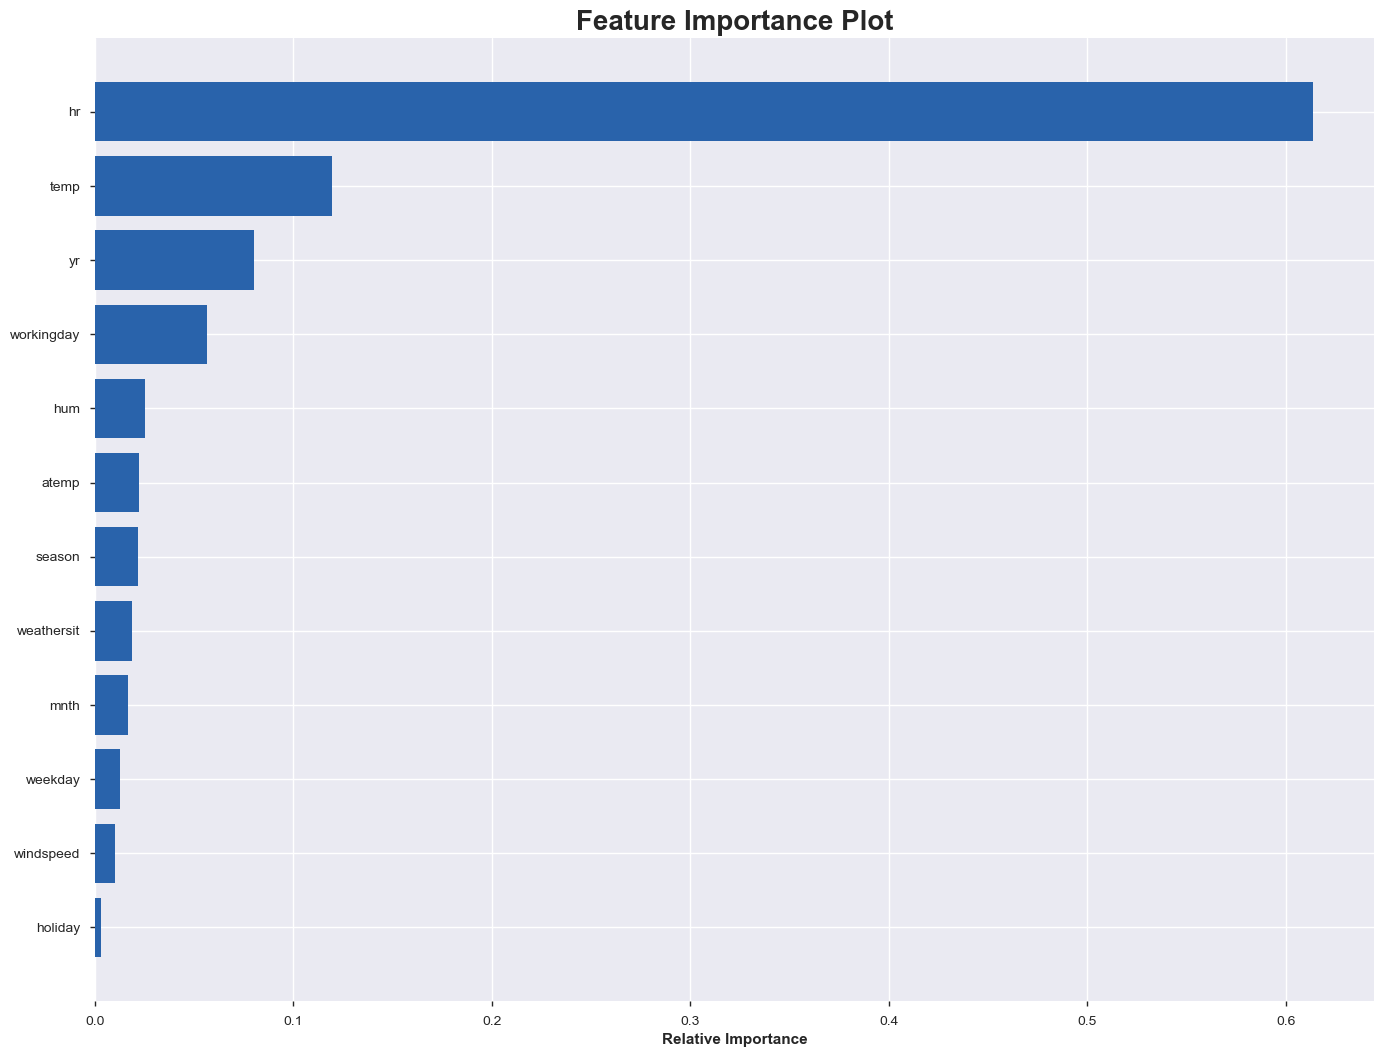

In [33]:
# Ploting graph to calculate important features in the dataset
clf_random = RandomForestRegressor(random_state=0)
clf_random.fit(X_t,y_t)
features = X_t.columns
importances = clf_random.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importance Plot',fontsize=20,fontweight="bold")
plt.barh(range(len(indices)), importances[indices], color='#2963ab', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance',fontweight="bold")
fig = plt.gcf()
fig.set_size_inches(16.5, 12.5, forward=True)
plt.show()



In [34]:
#Dropping unimportant variables
df1 = df1.drop(df1[['holiday']],axis=1)

In [35]:
#Splitting data into feature variables and target variables
X_data1 = df1.iloc[:, :-1]
y1 = df1.iloc[:, -1]

In [36]:
# Partition the dataset in train + validation sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_data1, y1, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train1.shape))
print("X_test : " + str(X_test1.shape))
print("y_train : " + str(y_train1.shape))
print("y_test : " + str(y_test1.shape))

X_train : (12165, 11)
X_test : (5214, 11)
y_train : (12165,)
y_test : (5214,)


RMSE on Training set : 47.200539969223314
RMSE on Test set : 55.26404103128668
R-squared 0.93


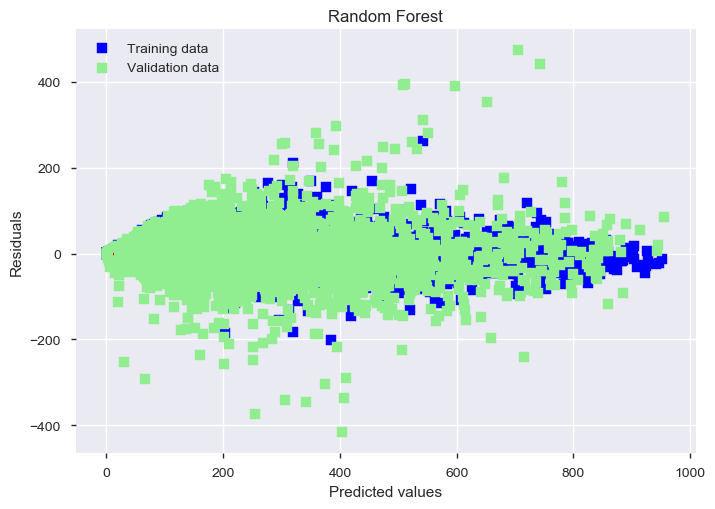

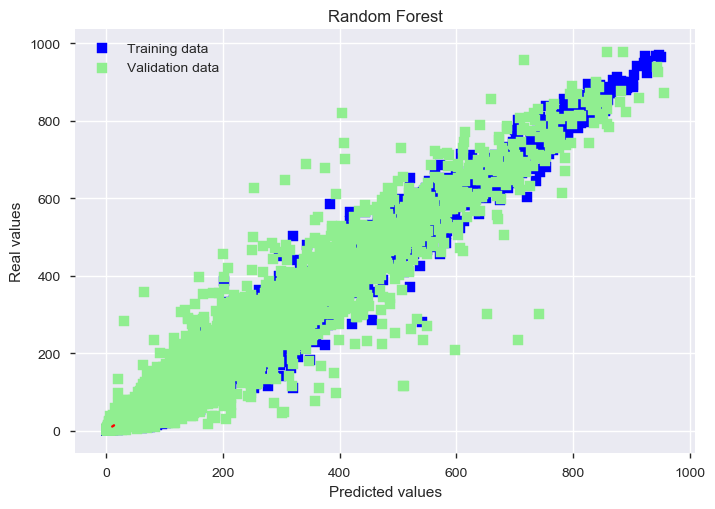

In [37]:
rml = RandomForestRegressor(random_state=0)
rml.fit(X_train1,y_train1)

# Look at predictions on training and validation set
print("RMSE on Training set :", rmse_cv_train1(rml).mean())
print("RMSE on Test set :", rmse_cv_test1(rml).mean())
y_train_pred1 = rml.predict(X_train1)
y_test_pred1 = rml.predict(X_test1)

test_score1 = rml.score(X_test1,y_test1) 
print("R-squared {:.2f}".format(test_score1))

# Plot residuals
plt.scatter(y_train_pred1, y_train_pred1 - y_train1, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred1, y_test_pred1 - y_test1, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Random Forest")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()


# Plot predictions
plt.scatter(y_train_pred1, y_train1, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred1, y_test1, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Random Forest")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()


### We can see from the results above that Random Forest has given better than Linear Regression and it has also decreased the variance.
### We do not require any normalization of variables as it taken care off by Random Forest model.